## Loading the Data

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import zipfile
import os

# Load the metadata
metadata = pd.read_csv('meta_data.csv')

# Create a dictionary mapping from image file name to is_training_image
is_training_image = dict(zip(metadata.augmented_image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

directory = "../augmented_images"

# Check if the directory exists
if os.path.isdir(directory):
    print("Directory exists skipping zip extraction")
else:
    print("Directory does not exist, extracting zip file...")

    # Specify the zip file name
    zip_file = "../augmented_images.zip"

    # Specify the directory to extract to
    extract_dir = "../"

    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all the contents of the zip file in the specified directory
        zip_ref.extractall(extract_dir)

print("Loading the dataset...")
# Load the dataset
dataset = ImageFolder(directory, transform=transform)

print("Splitting the dataset...")
# Split the dataset into training and testing sets
train_indices = [i for i, (img, label) in enumerate(dataset.imgs) if is_training_image[os.path.normpath(img).replace('\\', '/').replace("../", "./")]]
test_indices = [i for i, (img, label) in enumerate(dataset.imgs) if not is_training_image[os.path.normpath(img).replace('\\', '/').replace("../", "./")]]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print("Creating the data loaders...")
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[0]
show_example(img, label)

## Split Training Dataset into train and validation

In [ ]:
from torch.utils.data import random_split

# Define the size of the validation set
val_size = int(0.2 * len(train_dataset))  # 20% for validation
train_size = len(train_dataset) - val_size

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Training set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))

In [ ]:
import torchvision.utils as vutils

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(vutils.make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [35]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import zipfile
import os
import csv
from torch.utils.data import ConcatDataset
import numpy as np

# Load the metadata
metadata = pd.read_csv('meta_data.csv')
metadata['augmented_images_more'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_more')
metadata['augmented_image_nocrop_name'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_nocrop')

# Create a dictionary mapping from image file name to is_training_image

# Only add training images for augmented
temp = metadata[metadata.is_training_image == 1]

is_training_image = dict(zip(temp.augmented_image_name, temp.is_training_image))   # original augmentation
is_training_image.update(zip(temp.augmented_images_more, temp.is_training_image))  # more augmentation
is_training_image.update(zip(temp.augmented_image_nocrop_name, temp.is_training_image)) # augmented but no crop to bbox

# Add original data
# Test will be from original images (not cropped, only resize to 224,224)
is_training_image.update(zip(metadata.image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load or extract dataset
def load_or_extract(directory, zip_file):
    if os.path.isdir(directory):
        print(f"Directory {directory} exists, skipping zip extraction.")
    else:
        print(f"Directory {directory} does not exist, extracting zip file {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("./")
        print(f"Extracted {zip_file}.")

# Load or extract both datasets
load_or_extract("./augmented_images", "./augmented_images.zip")
load_or_extract("./CUB_200_2011/images", "./images.zip")
load_or_extract("./augmented_images_more","./augmented_images_more.zip")
load_or_extract("./augmented_images_nocrop","./augmented_images_nocrop.zip")

# Load datasets
dataset_augmented = ImageFolder("./augmented_images", transform=transform)
dataset_images = ImageFolder("./CUB_200_2011/images", transform=transform)
dataset_augmented_more = ImageFolder("./augmented_images_more", transform=transform)
dataset_augmented_nocrop = ImageFolder("./augmented_images_nocrop", transform=transform)


# Combine datasets
all_classes = sorted(set(dataset_images.classes + dataset_augmented.classes + dataset_augmented_more.classes + dataset_augmented_nocrop.classes))
combined_dataset = ConcatDataset([dataset_images, dataset_augmented, dataset_augmented_more, dataset_augmented_nocrop])
combined_dataset.classes = all_classes
print(combined_dataset)

def get_combined_indices(combined_dataset, is_training_image):
    train_indices, test_indices = [], []
    offset = 0  # Offset to account for different datasets in ConcatDataset
    for dataset in combined_dataset.datasets:
        for i, (img, _) in enumerate(dataset.imgs):
            # Construct relative path as used in is_training_image
            rel_path = "./" + os.path.normpath(img)
            if rel_path in is_training_image:  # Check if the image is in the dictionary
                if is_training_image[rel_path] == 1:
                    train_indices.append(i + offset)  # Image is for training
                else:
                    test_indices.append(i + offset)  # Image is for testing
        offset += len(dataset)  # Update offset for the next dataset
    return train_indices, test_indices


# Get combined train and test indices
#train_indices, test_indices = get_combined_indices(combined_dataset, is_training_image)
#test_indices, val_indices = train_test_split(test_indices, test_size=0.2, random_state=42)
#print(f"Number of training indices: {len(train_indices)}")
#print(f"Number of testing indices: {len(test_indices)}")
#print(f"Number of testing indices: {len(val_indices)}")

# Save the indices to .npy files
#np.save('train_indices.npy', train_indices)
#np.save('test_indices.npy', test_indices)
#np.save('val_indices.npy', val_indices)

# Load indices from .npy files (demonstration)
train_indices = np.load('train_indices.npy')
val_indices = np.load('val_indices.npy')
test_indices = np.load('test_indices.npy')

# Create training and testing subsets
train_dataset = Subset(combined_dataset, train_indices)
test_dataset = Subset(combined_dataset, test_indices)
val_dataset = Subset(combined_dataset, val_indices)

print("Creating the data loaders...")
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


"""## Split Training Dataset into train and validation"""

# from torch.utils.data import random_split

# # Define the size of the validation set as 20% of the original test dataset
# val_size = int(0.2 * len(test_dataset))
# new_test_size = len(test_dataset) - val_size

# # Split the original test dataset into new smaller test and validation sets
# new_test_dataset, val_dataset = random_split(test_dataset, [new_test_size, val_size])

# Create the data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# # Update the test_loader to use the new_test_dataset
# test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

print("Training set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))
print("Test set size: ", len(test_dataset))

Directory ./augmented_images exists, skipping zip extraction.
Directory ./CUB_200_2011/images exists, skipping zip extraction.
Directory ./augmented_images_more exists, skipping zip extraction.
Directory ./augmented_images_nocrop exists, skipping zip extraction.
Creating the data loaders...
Training set size:  23976
Validation set size:  1159
Test set size:  4634


## GoogleNet Transfer Learning Model Creation

In [39]:
import torch
from torch import nn
from torchvision.models import googlenet
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))
        

class GoogLeNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = googlenet(pretrained=True)

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last five layers
        for param in list(self.network.parameters())[-4:]:
            param.requires_grad = True

        # Replace the classifier with a custom one
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def unfreeze_all(self):
        for param in self.network.parameters():
            param.requires_grad = True
    
    def freeze_all_except_custom(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last 4 layer
        list(self.network.parameters())[-4].requires_grad = True

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

## Training the Model

In [40]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(all_classes)


def fit(epochs, lr, train_loader, val_loader, optimizer, model, weight_decay=0):
    optimizer = optimizer(model.parameters(), lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        print("Starting epoch ", epoch+1, " of ", epochs)
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch = (inputs, labels)
            # Compute predictions and losses
            outputs = model(inputs)
            loss = model.training_step(batch)
            train_losses.append(loss.item())
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels.data) / len(labels)
            train_accs.append(acc.item())
            # Backpropagation
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 1)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Record training loss and accuracy
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))

        # Validation phase
        model.eval()
        val_losses = []
        val_accs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                batch = (inputs, labels)
                # Compute predictions and losses
                loss = model.validation_step(batch)['val_loss']
                val_losses.append(loss.item())
                # Compute accuracy
                acc = model.validation_step(batch)['val_acc']
                val_accs.append(acc.item())
        # Record validation loss and accuracy
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_accs))
        print(f'Epoch {epoch+1}/{epochs}, train loss: {np.mean(train_losses):.4f}, val loss: {np.mean(val_losses):.4f}, val loss: {np.mean(val_losses):.4f}, train acc: {np.mean(train_accs):.4f}, val acc: {np.mean(val_accs):.4f}')
    return history

In [41]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

model = GoogLeNetModel(num_classes).to(device)
weight_decay = 0
model.unfreeze_all()

history = fit(num_epochs, lr, train_loader, val_loader, opt_func, model, weight_decay)

Starting epoch  1  of  20
Epoch 1/20, train loss: 4.9083, val loss: 3.6338, val loss: 3.6338, train acc: 0.0468, val acc: 0.2616
Starting epoch  2  of  20
Epoch 2/20, train loss: 2.7923, val loss: 1.7131, val loss: 1.7131, train acc: 0.2968, val acc: 0.5420
Starting epoch  3  of  20
Epoch 3/20, train loss: 1.6874, val loss: 1.3299, val loss: 1.3299, train acc: 0.5204, val acc: 0.6240
Starting epoch  4  of  20
Epoch 4/20, train loss: 1.4213, val loss: 1.4105, val loss: 1.4105, train acc: 0.5850, val acc: 0.6046
Starting epoch  5  of  20
Epoch 5/20, train loss: 1.3227, val loss: 1.3666, val loss: 1.3666, train acc: 0.6119, val acc: 0.6362
Starting epoch  6  of  20
Epoch 6/20, train loss: 1.1640, val loss: 1.2114, val loss: 1.2114, train acc: 0.6579, val acc: 0.6713
Starting epoch  7  of  20
Epoch 7/20, train loss: 0.9916, val loss: 1.0720, val loss: 1.0720, train acc: 0.7012, val acc: 0.7034
Starting epoch  8  of  20
Epoch 8/20, train loss: 0.8580, val loss: 0.9760, val loss: 0.9760, tra

In [33]:
history_new = {}

# history_new['val_acc'] = history['val_acc'][20:]
# history_new['train_loss'] = history['train_loss'][20:]
for key in history.keys():
    history_new[key] = history[key][20:]
    history[key] = history[key][20:]

In [34]:
num_epochs = 10

history = fit(num_epochs, lr, train_loader, val_loader, opt_func, model, weight_decay)

Starting epoch  1  of  10


KeyboardInterrupt: 

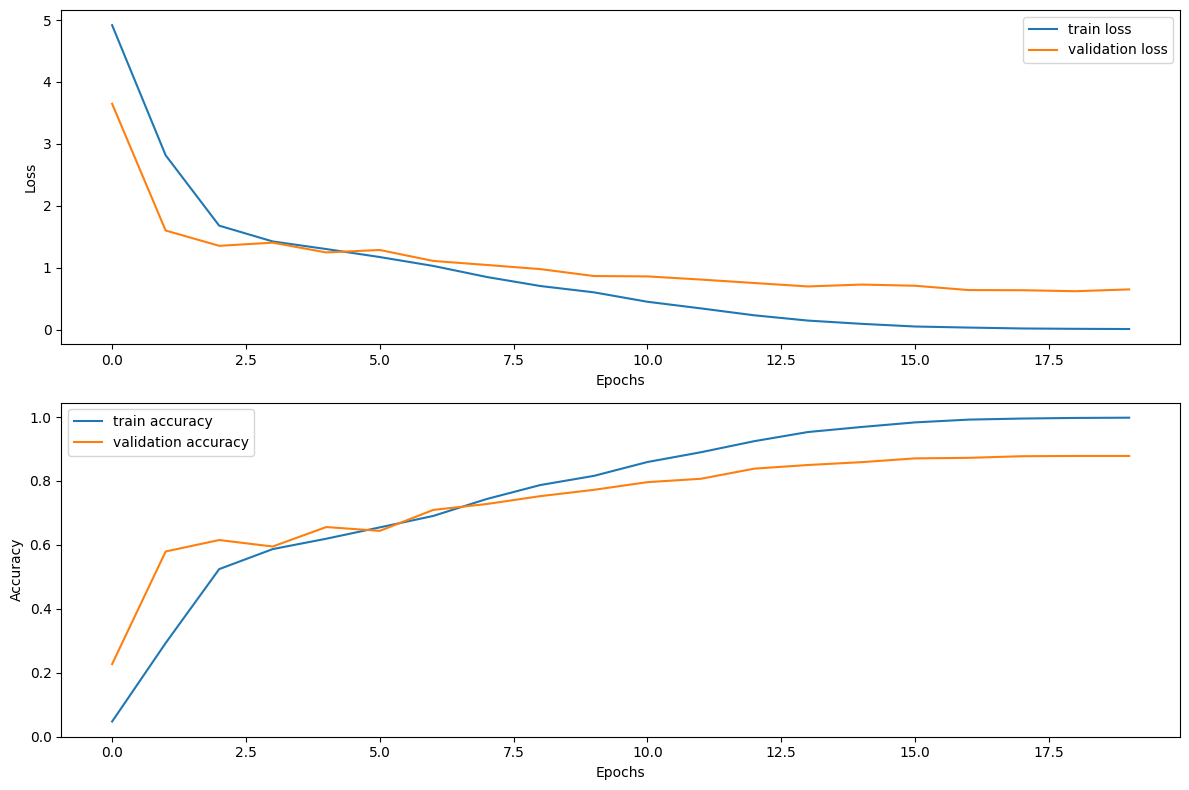

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('googlenet_train_val_acc_loss_best_3.png') 

plot_history(history_new)


## Test the Model

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

test_model(model, test_loader, device)

## Save the Model

In [ ]:
# Save the trained model
torch.save(model, 'googlenet_best_3.pth')